# Tarea 1 FIS2436

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources,detect_threshold,deblend_sources,SourceCatalog
from photutils.isophote import EllipseGeometry,Ellipse
from photutils.aperture import EllipticalAperture

Link utilizado: https://www.legacysurvey.org/viewer/fits-cutout?ra=132.8503&dec=25.1559&layer=ls-dr10&pixscale=0.262&bands=grz&size=1024

Referencia: https://www.legacysurvey.org/dr10/description/

Coordenadas: RA=132.8503 y DEC=25.155

In [2]:
#Abrimos el fits y vemos que hay
imagen=fits.open('imagen10.fits')
imagen.info()

Filename: imagen10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (1024, 1024, 3)   float32   


In [3]:
#Extraemos los datos del fits
layers=imagen[0].data

In [4]:
#Separamos los filtros, del más azul al más rojo (la info de cuál es cuál está en el header)
g_layer=layers[0]
r_layer=layers[1]
z_layer=layers[2]

In [5]:
data=r_layer #Para hacer más fácil cambiar de filtro

In [6]:
#Estimamos el ruido de background para ver si es necesario sacarlo
bkg_estimator = MedianBackground()
bkg = Background2D(data, 64, filter_size=5, bkg_estimator=bkg_estimator)
bdata = g_layer-bkg.background
data-bdata

array([[-0.00797584, -0.00326424, -0.00047771, ...,  0.00323674,
         0.00332633,  0.00469367],
       [-0.00130982,  0.00162975, -0.00048896, ..., -0.00221621,
        -0.00213528,  0.00467142],
       [ 0.00295744,  0.0032334 , -0.0012912 , ..., -0.00909915,
        -0.00421513,  0.00217177],
       ...,
       [ 0.00704458, -0.00403591, -0.00596895, ...,  0.00381705,
         0.00341367, -0.0033933 ],
       [ 0.00024413, -0.00583043, -0.00164941, ...,  0.00048357,
        -0.00643762, -0.00114912],
       [-0.00012312,  0.00303435, -0.00317699, ..., -0.00427912,
        -0.00920135,  0.00345079]])

Como vemos el ruido de background es bajísimo (tiene sentido ya que los datos ya están reducidos), no es necesario corregirlo, así que ya podemos preceder a identificar fuentes, hechemos un vistazo a la imagen

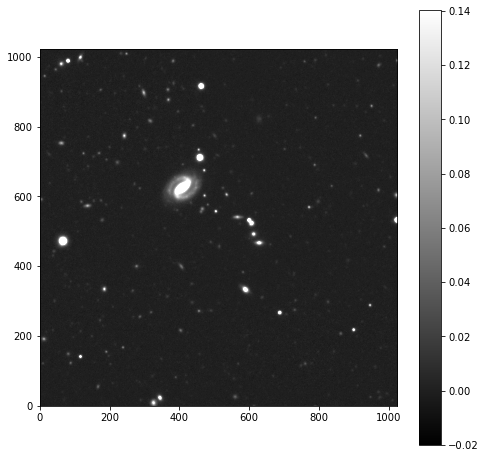

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(data,cmap='gray', origin='lower',\
           vmin=-0.02, vmax=np.mean(data)+np.std(data))
plt.colorbar()
plt.show()

## Catálogo

In [8]:
#Calculamos el threshold
threshold= detect_threshold(data, nsigma=3)

In [9]:
#Generamos nuestro mapa de fuentes simple (el mínimo de pixeles por fuente es 5)
mapa= detect_sources(data,threshold, npixels=5)
mapa

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 243
labels: [  1   2   3   4   5 ... 239 240 241 242 243]

In [10]:
#Generamos otro mapa de fuentes segementadas para separar fuentes que estén muy pegadas
segm_map = deblend_sources(data, mapa, contrast=0.1 ,npixels=5, progress_bar=False)
segm_map

<photutils.segmentation.core.SegmentationImage>
shape: (1024, 1024)
nlabels: 254
labels: [  1   2   3   4   5 ... 250 251 252 253 254]

Veamos como se ven estos mapas

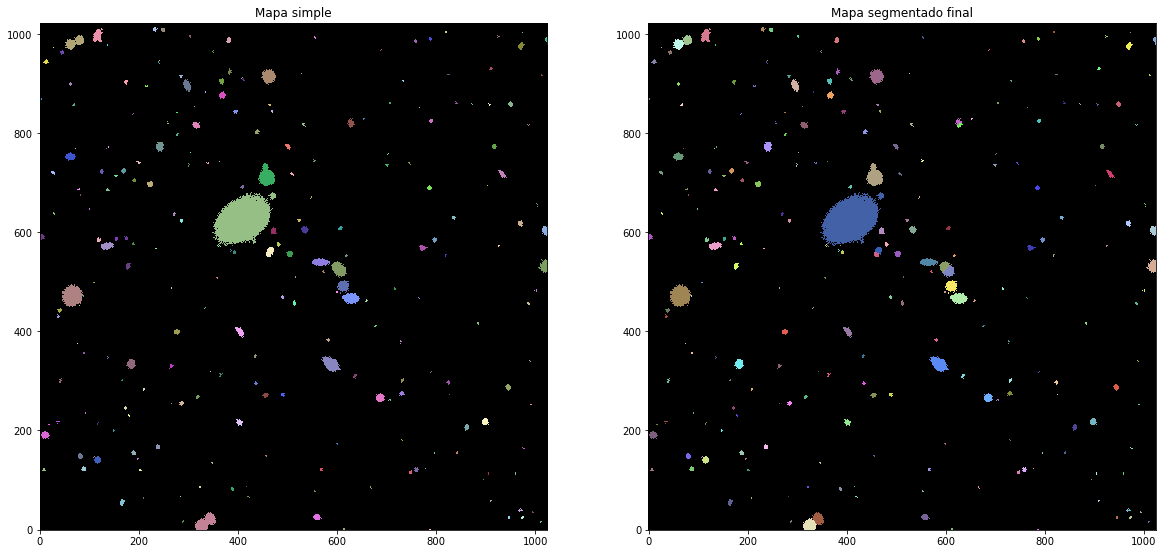

In [184]:
cmapa = mapa.make_cmap(seed=1) #generamos un mapa de colores para diferenciar las fuentes
cmapa2 = segm_map.make_cmap(seed=2)

fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(mapa,cmap=cmapa, origin="lower", interpolation='nearest')
axs[0].set_title('Mapa simple')

axs[1].imshow(segm_map,cmap=cmapa2, origin="lower", interpolation='nearest')
axs[1].set_title('Mapa segmentado final')
plt.show()

In [13]:
#generamos nuestro catálogo simple y lo pasamos a tabla
cat=SourceCatalog(data,segm_map)
tbl=cat.to_table()
cat

In [16]:
tbl

#Generamos nuestra imagen a color
rgb=make_lupton_rgb(z_layer,r_layer,g_layer, minimum=0, stretch=0.1, Q=8)

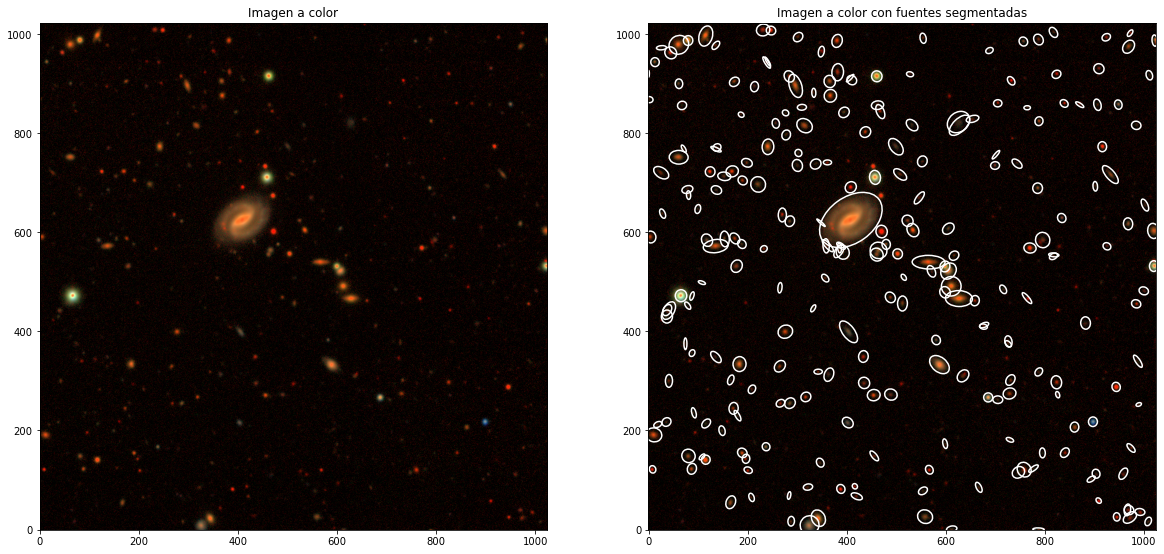

In [183]:
fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(rgb, origin='lower',\
           vmin=0, vmax=np.mean(rgb)+np.std(rgb))
axs[0].set_title('Imagen a color')

axs[1].imshow(rgb, origin='lower',\
           vmin=0, vmax=np.mean(rgb)+np.std(rgb))
axs[1].set_title('Imagen a color con fuentes segmentadas')
cat.plot_kron_apertures(color='white', lw=1.5)
plt.show()

## Isofotas

In [185]:
obj1=g_layer[525:725,300:500]

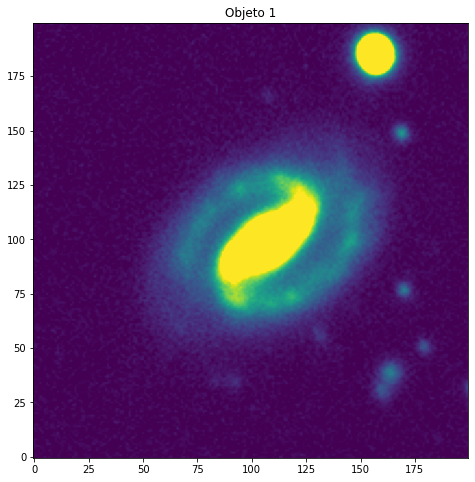

In [186]:
plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',\
           vmin=0, vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Objeto 1')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f0371dd3880>,)

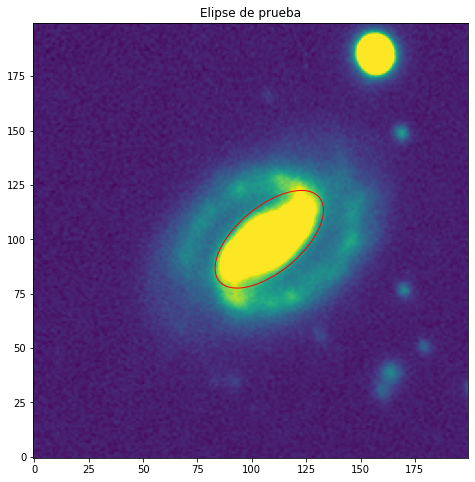

In [194]:
#Generamos nuestra elipse de prueba con los siguientes elementos :
#   (x0,y0) son las coordenadas centrales de la elipse
#   sma es la medida del semieje mayor (en pixeles)
#   eps es la elipticidad
#   pa es el ángulo (en radianes) respecto al eje x

geometry = EllipseGeometry(x0=108, y0=100, sma=30, eps=0.5,pa=40.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

In [195]:
def isofogen(obj,geo_obj): #Función para generar una lista de isofotas 
    return Ellipse(obj,geo_obj).fit_image()

In [196]:
def aper(f,x): #Función para graficar isofotas
    return EllipticalAperture((f.x0[x], f.y0[x]), f.sma[x],\
                          f.sma[x] * (1 - f.eps[x]),f.pa[x])

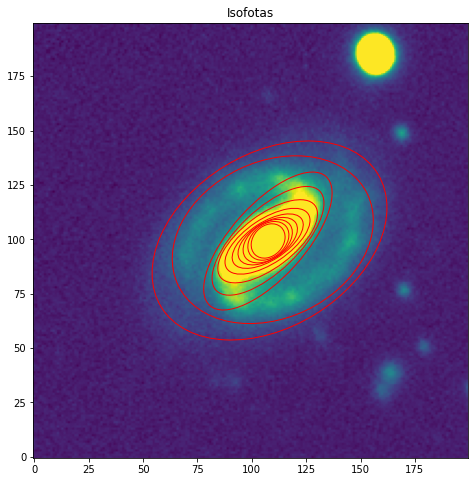

In [199]:
iso1=isofogen(obj1,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Isofotas')
for i in range (30,52,2):
    aper(iso1,i).plot(color='red')

Hagamos lo mismo para 8 objetos más

### Objeto 2

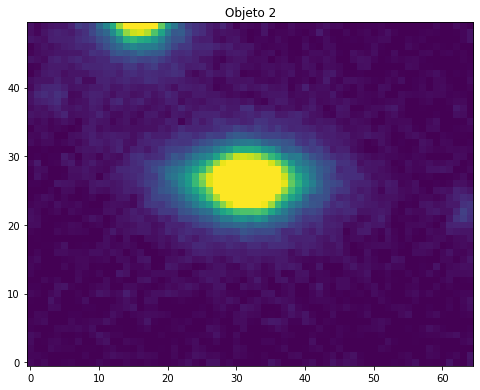

In [49]:
#Definimos el objeto
obj2=data[440:490,595:660]

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',\
           vmin=0, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 2')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f0373492d60>,)

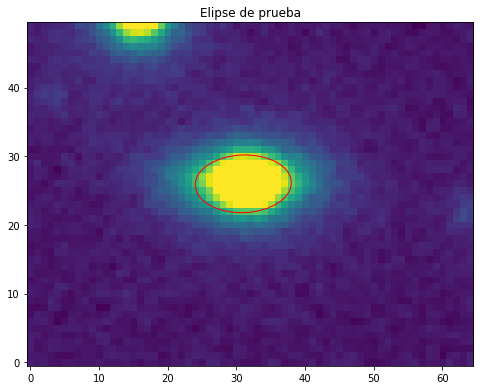

In [57]:
#Elipse de prueba
geometry = EllipseGeometry(x0=31, y0=26, sma=7, eps=0.4,pa=2.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

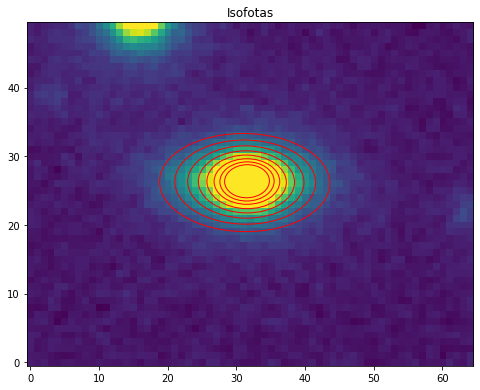

In [63]:
#Generamos y graficamos las isofotas
iso2=isofogen(obj2,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (20,36,2):
    aper(iso2,i).plot(color='red')

### Objeto 3

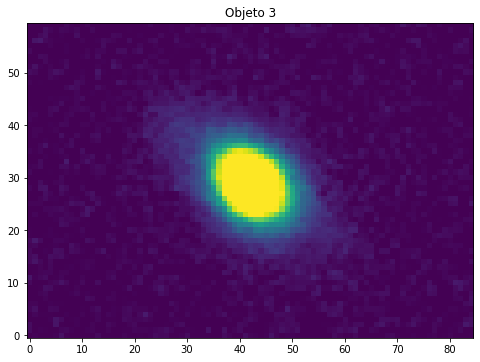

In [74]:
#Definimos el objeto
obj3=data[304:364,545:630]

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',\
           vmin=0, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 3')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f03730c9040>,)

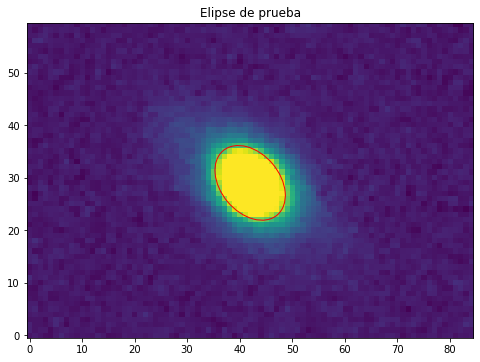

In [82]:
#Elipse de prueba
geometry = EllipseGeometry(x0=42, y0=29, sma=8, eps=0.3,pa=-50.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

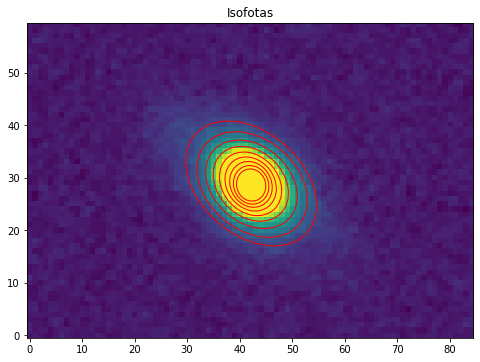

In [85]:
#Generamos y graficamos las isofotas
iso3=isofogen(obj3,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (20,38,2):
    aper(iso3,i).plot(color='red')

### Objeto 4

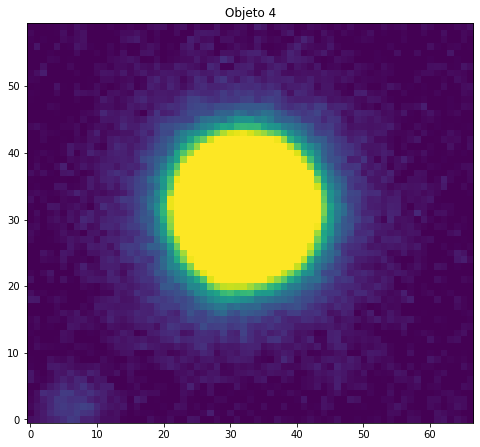

In [87]:
#Definimos el objeto
obj4=data[440:500,33:100]

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',\
           vmin=0, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 4')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f0372f2b850>,)

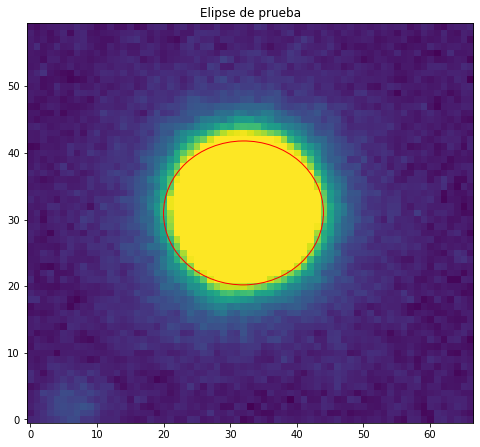

In [91]:
#Elipse de prueba
geometry = EllipseGeometry(x0=32, y0=31, sma=12, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

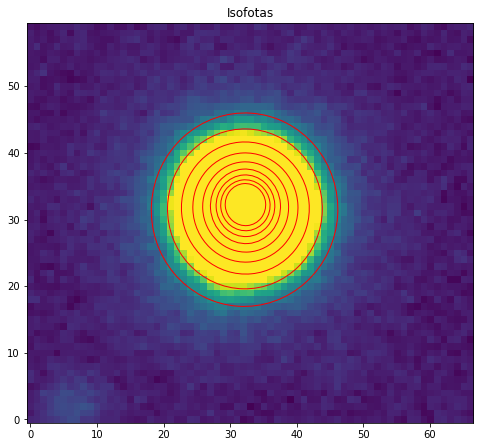

In [92]:
#Generamos y graficamos las isofotas
iso4=isofogen(obj4,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (20,38,2):
    aper(iso4,i).plot(color='red')

### Objeto 5

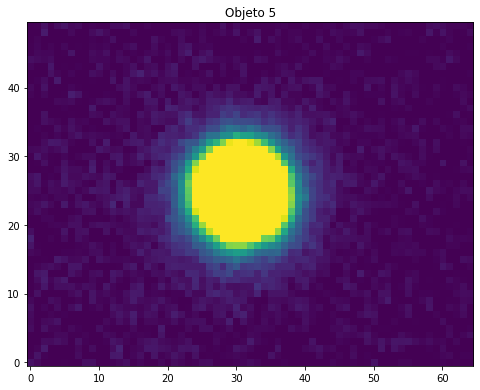

In [98]:
#Definimos el objeto
obj5=data[890:940,430:495]

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',\
           vmin=0, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 5')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f0372b9eaf0>,)

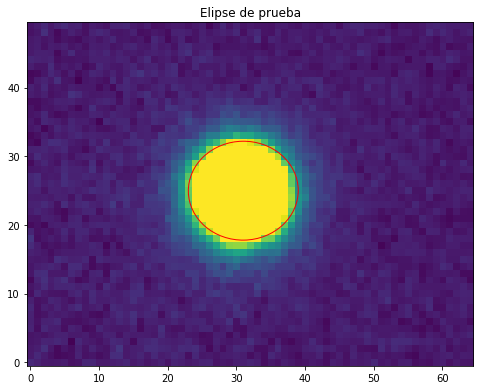

In [104]:
#Elipse de prueba
geometry = EllipseGeometry(x0=31, y0=25, sma=8, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

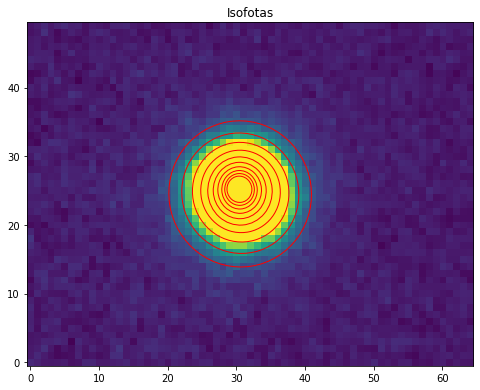

In [107]:
#Generamos y graficamos las isofotas
iso5=isofogen(obj5,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (15,34,2):
    aper(iso5,i).plot(color='red')

### Objeto 6

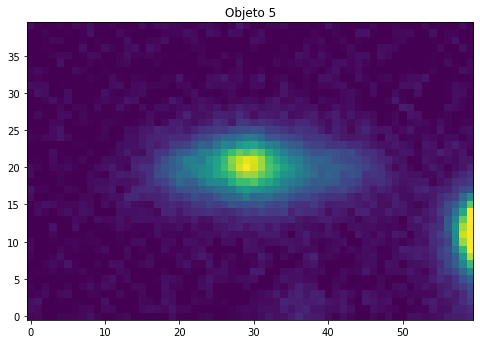

In [115]:
#Definimos el objeto
obj6=data[520:560,535:595]

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',\
           vmin=0, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 6')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f0373337c40>,)

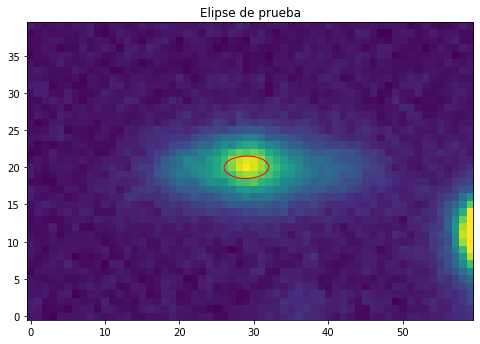

In [121]:
#Elipse de prueba
geometry = EllipseGeometry(x0=29, y0=20, sma=3, eps=0.5,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

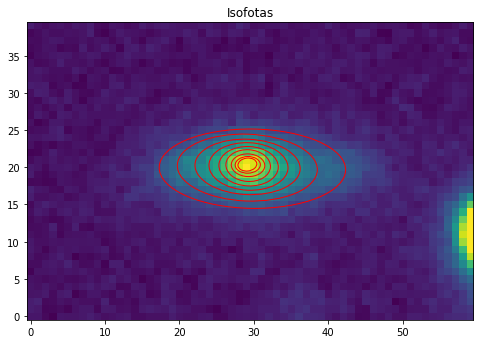

In [130]:
#Generamos y graficamos las isofotas
iso6=isofogen(obj6,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (10,36,3):
    aper(iso6,i).plot(color='red')

### Objeto 7

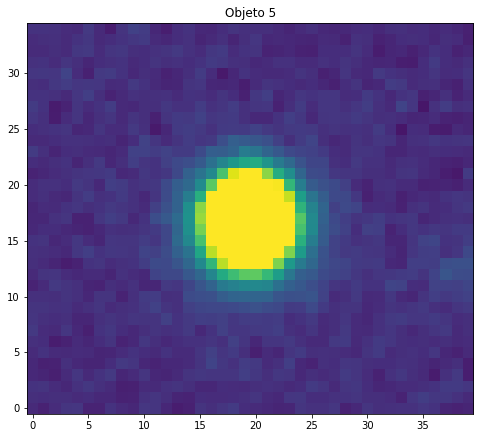

In [138]:
#Definimos el objeto
obj7=data[250:285,666:706]

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',\
           vmin=-0.02, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 7')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f037284f6a0>,)

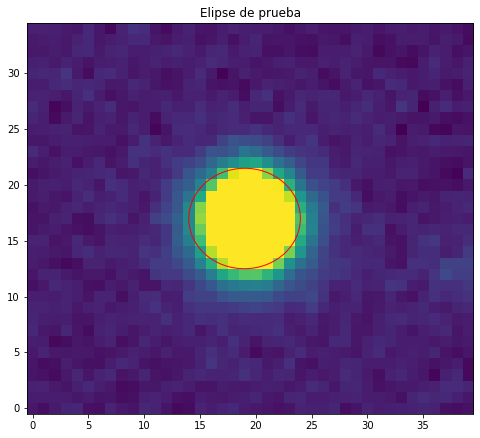

In [141]:
#Elipse de prueba
geometry = EllipseGeometry(x0=19, y0=17, sma=5, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

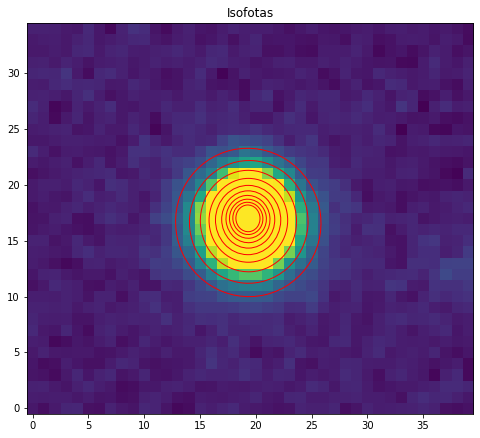

In [143]:
#Generamos y graficamos las isofotas
iso7=isofogen(obj7,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (10,30,2):
    aper(iso7,i).plot(color='red')

### Objeto 8

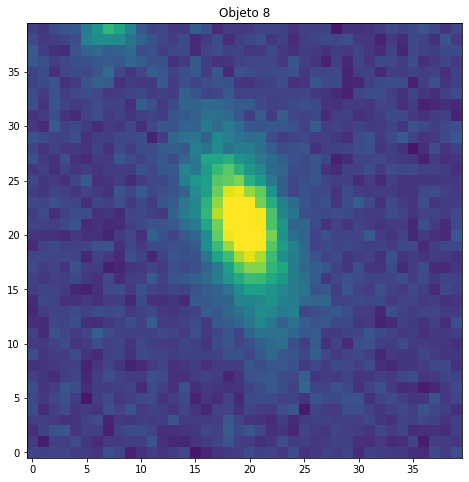

In [160]:
#Definimos el objeto
obj8=z_layer[875:915,277:317]

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',\
           vmin=-0.05, vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Objeto 8')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f03720821c0>,)

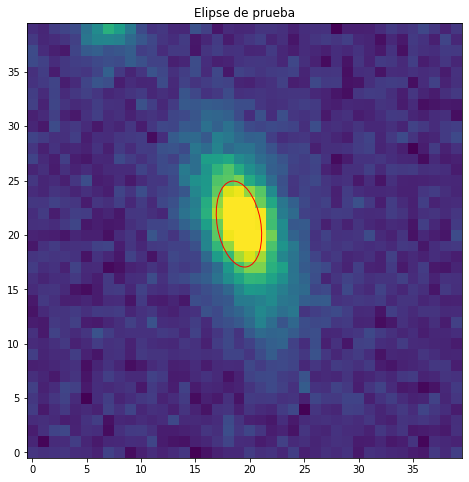

In [166]:
#Elipse de prueba
geometry = EllipseGeometry(x0=19, y0=21, sma=4, eps=0.5,pa=-80.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

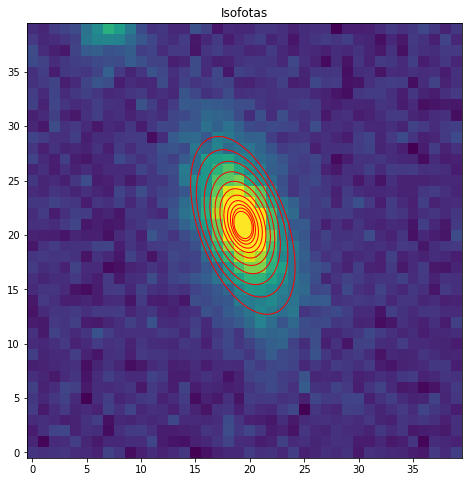

In [168]:
#Generamos y graficamos las isofotas
iso8=isofogen(obj8,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Isofotas')
for i in range (10,32,2):
    aper(iso8,i).plot(color='red')

### Objeto 9

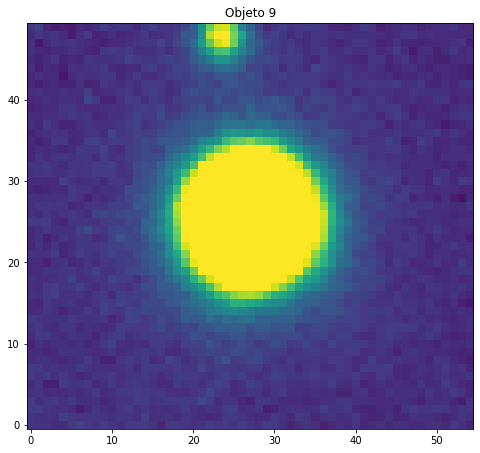

In [173]:
#Definimos el objeto
obj9=data[685:735,430:485]

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',\
           vmin=-0.02, vmax=np.mean(data)+np.std(data))
plt.title('Objeto 9')
plt.show()

(<matplotlib.patches.Ellipse at 0x7f03724e4dc0>,)

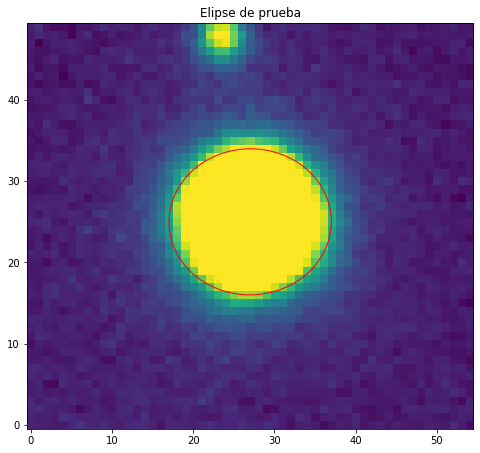

In [177]:
#Elipse de prueba
geometry = EllipseGeometry(x0=27, y0=25, sma=10, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Elipse de prueba')
apert.plot(color='red')

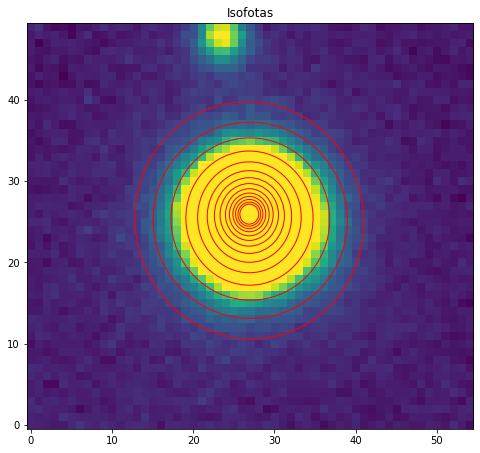

In [182]:
#Generamos y graficamos las isofotas
iso9=isofogen(obj9,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',vmax=np.mean(data)+np.std(data))
plt.title('Isofotas')
for i in range (10,38,2):
    aper(iso9,i).plot(color='red')